In [0]:
#Import necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline

In [0]:
# Load necessary CSV Files - ratings.csv, movies.csv.

movies = pd.read_csv("/content/drive/My Drive/datasets/movies.csv")
ratings = pd.read_csv("/content/drive/My Drive/datasets/ratings.csv")

In [18]:
#contents in the movies.csv file

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [19]:
#contents in the ratings.csv file

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [20]:
#minimum rating given to a movie

ratings['rating'].min() 

0.5

In [21]:
#maximum rating given to a movie

ratings['rating'].max()

5.0

In [22]:
#Total length of ratings table

len(ratings)

100836

In [23]:
#is any row null

movies.isnull().any()

movieId    False
title      False
genres     False
dtype: bool

In [0]:
#is any row null

ratings.isnull().any()

userId     False
movieId    False
rating     False
dtype: bool

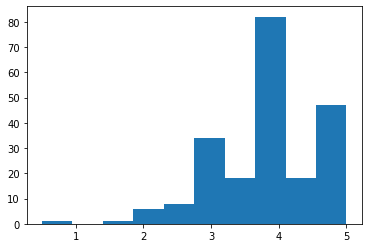

In [26]:
#The above plot shows that the movie 'Toystory' has got 4 (stars) maximum

toystory_data = ratings[ratings.movieId==1]

plt.hist(x=toystory_data['rating'])
plt.show()

In [0]:
del ratings['timestamp']

In [0]:
print(len(ratings.userId.unique()))     #unique users
print(len(ratings.movieId.unique()))    #unique movies

610
9724


In [0]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count



In [0]:
#here we  make census of the genres:
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [0]:
#counting how many times each of genres occur:
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)

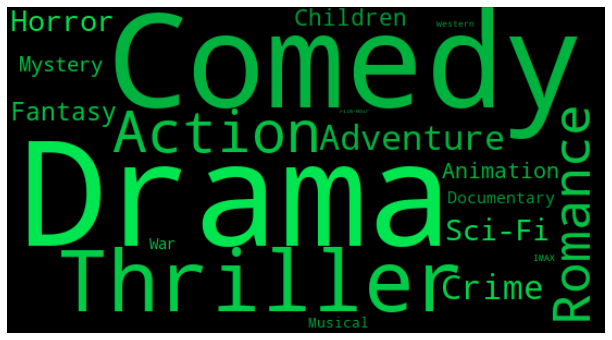

In [0]:
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

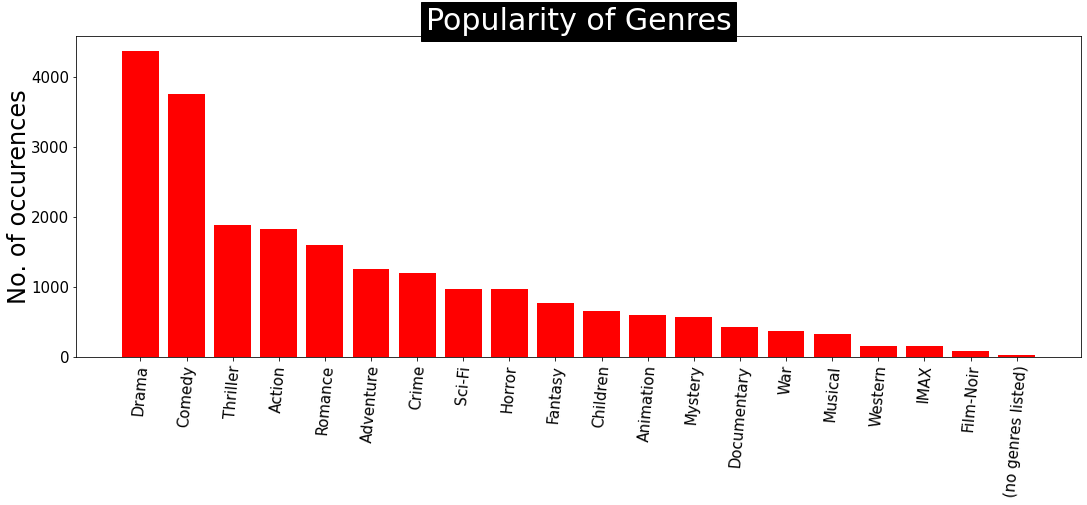

In [0]:
# lets display the same result in the histogram
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [0]:
#Buiding a list of dictionaries where each dictionary represents a movie. user_id is the key and corresponding rating is its value. 

listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0;
test = ratings
test=test[['userId','rating']].groupby(test['movieId'])     # group the ratings table by movie Id

#test.groups -------> To view the groups created
#test.groups.keys() --------------> Gives the keys i.e movie ids

for groupKey in test.groups.keys():
    tempDict={}

    group = test.get_group(groupKey)   #get a group(consists od rating and userid) of particular movieId

    for i in range(0,len(group)):
        tempDict[group.iloc[i,0]]=group.iloc[i,1]
    indexMap[ptr]=groupKey                        #A dictionary where key is indexed value(0,1,2 ....) and value is movieId     
    reverseIndexMap[groupKey] = ptr               #Reverse of indexMap. Here movieId is key and index is value
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

In [0]:
#We then use sklearn's DictVectorizer() function to create vectors corresponding to each movie. We are trying to create a vector space with users as column 
#vectors. Each point in the vector space represents a movie. Rating of the movie given an user is its magnitude. We then calculate similarity/distance between 
#movies in this vector space.


from sklearn.feature_extraction import DictVectorizer
dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)

###We will use cosine similarity to measure distance.Why? 

Because, cosine distance works comparatively good on vectors than euclidean etc. metrics.
Here's the formula which is used to calculate cosine distance.
cosine-distance

![alt text](https://distilledai.com/wp-content/uploads/2020/04/cosine-similarity.png)

In [0]:
#We finally use sklearn's consine_similarity function to calculate pairwise similarity matrix

from sklearn.metrics.pairwise import cosine_similarity
pairwiseSimilarity = cosine_similarity(vector)
print(pairwiseSimilarity)       #gives a matrix of distances between 2 vectors

[[1.         0.41056206 0.2969169  ... 0.         0.         0.        ]
 [0.41056206 1.         0.28243799 ... 0.         0.         0.        ]
 [0.2969169  0.28243799 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [0]:
#At last we define a function that takes an input id(movie Id) and outputs 5 top most recomendations

def moviedetails(movie_id):
    print("Title:", movies[movies['movieId']==movie_id]['title'].values[0])
    print("Genres:",movies[movies['movieId']==movie_id]['genres'].values[0])
    print("Printing Movie-ID:",movie_id)
    print("-"*60)



#np.argsort(pairwiseSimilarity[row]) gives the sorted array of similarities of given row. This sorts in ascendending order of similarity
#But we need highest simialr matrix. So we fetch from last.But the last first movie is the movie itself. So we leave that fetch from second last one using 
#[-7:-2] i.e it fetches from last 7th element to last 2nd element. To reverse that order we use [::-1] 
def topRecommandations(movie_id):
    row = reverseIndexMap[movie_id]
    print("+++++------Movie entered--------+++++")
    moviedetails(movie_id)
    print("\n\n")
    print("*****-------Recommendations----------*****")

    similarMovieIDs = [moviedetails(indexMap[i]) for i in np.argsort(pairwiseSimilarity[row])[-7:-2][::-1]]

### Let's find out similar movies of "Star wars (1977)" movie

In [0]:
topRecommandations(260)

+++++------Movie entered--------+++++
Title: Star Wars: Episode IV - A New Hope (1977)
Genres: Action|Adventure|Sci-Fi
Printing Movie-ID: 260
------------------------------------------------------------



*****-------Recommendations----------*****
Title: Star Wars: Episode VI - Return of the Jedi (1983)
Genres: Action|Adventure|Sci-Fi
Printing Movie-ID: 1210
------------------------------------------------------------
Title: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Genres: Action|Adventure
Printing Movie-ID: 1198
------------------------------------------------------------
Title: Matrix, The (1999)
Genres: Action|Sci-Fi|Thriller
Printing Movie-ID: 2571
------------------------------------------------------------
Title: Indiana Jones and the Last Crusade (1989)
Genres: Action|Adventure
Printing Movie-ID: 1291
------------------------------------------------------------
Title: Back to the Future (1985)
Genres: Adventure|Comedy|Sci-Fi
Printing Movie-

### Cool !!

### What a Recommendation..

"Return of the Jedi (1983)" is Star Wars movie and other movies are also Sci-Fi and Action movie 